### Load Library

In [1]:
#Load library
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import time
from math import sqrt
import random
import matplotlib as matplt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, normalize, MinMaxScaler, LabelEncoder
from fastFM import als
from sklearn.metrics import mean_absolute_error, mean_squared_error

from surprise import KNNBasic
from surprise import Dataset
from surprise.model_selection import cross_validate

### Load Data

In [2]:
#Load data
path = "data/up-selling/peotv/"

#Ratings
ratings = pd.read_csv(path+'azure/peoTV_user_ratings.csv')

#Packages
packages = pd.read_csv(path+'peoTV_package_content.csv')

#Users
users = pd.read_csv(path+'peoTV_user_content.csv')

try:
    users.drop(["Unnamed: 0"],axis=1,inplace=True)
    packages.drop(["Unnamed: 0"],axis=1,inplace=True)
    ratings.drop(["Unnamed: 0"],axis=1,inplace=True)
except:
    pass



### PARAMETER DEFINTIONS

In [3]:
USER_COLUMNS = [ "ACCOUNT_NUM.hash", "Voice_INCOMING_Scaled", 
            "Location_Identifier", "Location_Node",  "Package_Type_and_Medium", "Model", "Service_Status",
            "Voice_OUTGOING_Scaled", "IDD_INCOMING_Scaled", "IDD_incoming_country",
            "IDD_OUTGOING_Scaled", "IDD_outgoing_country", "BB_Scaled", "BB_Package", "GENDER", "AGE",
            "Subscription", "Sub_Type", "Sub_Usage", "Sub_Type_State", "Megaline_Package", 
            "Megaline_Medium", "Megaline_Rental_Scaled", "FTTH_Package",
            "FTTH_Month_Subscribed", "FTTH_Medium", "FTTH_Rental_Scaled", "LTE_Package", "LTE_Medium","LTE_Rental_Scaled",
            "VAS_Package", "Product_Type", "VAS_Medium", "VAS_Rental_Scaled", "Sub_Update_Status", "Sub_Update",
            "BB_Extra_GB_Amount", "BB_Extra_GB_Hour_Subscribed", "BB_Extra_GB_Usage_Times",
            "BB_Extra_GB_Purchased_Scaled", "BB_Extra_GB_Subscribed_Night" ,"BB_Extra_GB_Subscribed_Day",
            "BB_Extra_GB_Rental_Scaled", "Peo_Extra_Channels_Cumulative_Rental", "Peo_Extra_Channels_Purchased_Scaled",
            "Peo_Extra_Channels_Purchased_Categorical", "Bill_Outstanding_Balance", "Bill_Billing_Status",
            "Payment_Status", "Package_Formatted", "TARIFF_DESC", "TARIFF_NAME", "Having_Insurance",
            "Having_Senior_Citizen_Scaled","Having_Kids_at_Home_Scaled","SMEs_Scaled",
            "Having_Teenagers_Students_Scaled","Having_Working_Professionals_Scaled","Having_Family_Member_Abroad_Scaled",
            "Tamil_Customer"]

PACKAGE_COLUMNS = ["package", 'Title', 'Price', 'Monthly_Rental',
            'PEOTV_No_of_Channels', 'PEOTV_Foreign_Channels','PEOTV_Local_Channels', 'PEOTV_Movie_Channels', 
            'PEOTV_Kids_Channels','PEOTV_Religious_Channels', 'PEOTV_Tamil_Channels','PEOTV_Educational_Channels', 
            'PEOTV_Music_Channels','PEOTV_Sports_Channels', 'PEOTV_News_Channels', 'PEOTV_HD_Pack']

ITEM_COLUMN = "itemId"
USER_COULMN = "userId"
RATING_COLUMN = "rating"
OUTLIER_COLUMNS = ["Voice_INCOMING_Outlier","Voice_OUTGOING_Outlier"]

## Pre Processing

In [4]:
# one hot encoder
def oneHotEncoder(array_1d):
    label = LabelEncoder().fit_transform(array_1d)
    label = label.reshape(len(label), 1)
    one_hot = OneHotEncoder(sparse=False).fit_transform(label)
    return one_hot

# min-max scaler
def minMaxScale(array_2d):
    return MinMaxScaler().fit_transform(array_2d)

# Turkey's box-plot method to clip outliers
def outliers(s, replace=np.nan):
    Q1, Q3 = np.percentile(s, [25 ,75])
    IQR = Q3-Q1
    return s.where((s > (Q1 - 1.5 * IQR)) & (s < (Q3 + 1.5 * IQR)), replace)

# clip outliers
def drop_numerical_outliers(df, cols):
  df[cols] = df[cols].apply(outliers)
  return df

# handle pre-defined outliers
def handle_outliers(df, cols):
  for col in cols:
    df = df[(df[col] != "YES")]
  return df

# drop unwanted cols
def drop_cols(df, columns):
  cols_to_drop = []
  for col in columns:
    if col not in df.columns:
      cols_to_drop.append(col)
  return df.drop(cols_to_drop, axis=1)


def expand_df(df, lst_cols, fill_value=''):
    # make sure `lst_cols` is a list
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)

    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()

    if (lens > 0).all():
        # ALL lists in cells aren't empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        # at least one list in cells is empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

In [5]:
# drop unused columns for analysis
users.drop(columns=[col for col in users if col not in USER_COLUMNS], inplace=True)
packages.drop(columns=[col for col in packages if col not in PACKAGE_COLUMNS], inplace=True)

ratings.columns = [USER_COULMN, ITEM_COLUMN, RATING_COLUMN]
packages.rename(columns = {'package':ITEM_COLUMN}, inplace = True)
users.rename(columns = {'ACCOUNT_NUM.hash':USER_COULMN}, inplace = True)

ratings.sort_values(by=[USER_COULMN,RATING_COLUMN],inplace=True,ascending=False)
ratings = ratings.drop_duplicates(keep="first").reset_index().drop("index", axis=1)

### Data Quality

In [6]:
#Data quality
print('Duplicated rows in ratings file: ' + str(ratings.duplicated().sum()))

n_users = ratings[USER_COULMN].unique().shape[0]
n_packages = ratings[ITEM_COLUMN].unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of packages: {}'.format(n_packages))
print('Sparsity: {:4.3f}%'.format(float(ratings.shape[0]) / float(n_users*n_packages) * 100))

Duplicated rows in ratings file: 0
Number of users: 19019
Number of packages: 49
Sparsity: 9.579%


In [7]:
# packages = expand_df(packages, ['Genres'])
# df_dummy = pd.get_dummies(ratings_ffm['Genres'])

In [8]:
rating_package = pd.merge(ratings,packages,how='left',on=ITEM_COLUMN)
final_df = pd.merge(rating_package,users,how='left',on=USER_COULMN)

In [9]:
scalable_cols = []

for col in final_df._get_numeric_data().columns:
    if final_df[col].max() > 1.0:
        scalable_cols.append(col)

# Min Max Scaler for all cols above value 1
scaler = MinMaxScaler()

final_df[scalable_cols] = scaler.fit_transform(final_df[scalable_cols])

final_df.describe()

,rating,Price,Monthly_Rental,PEOTV_No_of_Channels,PEOTV_Foreign_Channels,PEOTV_Local_Channels,PEOTV_Movie_Channels,PEOTV_Kids_Channels,PEOTV_Religious_Channels,PEOTV_Tamil_Channels,...,BB_Extra_GB_Rental_Scaled,Peo_Extra_Channels_Cumulative_Rental,Peo_Extra_Channels_Purchased_Scaled,Bill_Outstanding_Balance,Having_Senior_Citizen_Scaled,Having_Kids_at_Home_Scaled,SMEs_Scaled,Having_Teenagers_Students_Scaled,Having_Working_Professionals_Scaled,Having_Family_Member_Abroad_Scaled
count,89307.000000,88066.0,88066.000000,88066.000000,88066.000000,88066.000000,88066.000000,88066.000000,88066.000000,88066.000000,...,80931.000000,80931.000000,80931.000000,80931.000000,80931.000000,80931.000000,80931.000000,80931.000000,80931.000000,80931.000000
mean,0.424245,0.0,0.310262,0.452640,0.333217,0.654487,0.143893,0.267062,0.661427,0.145462,...,0.003822,0.029823,0.012855,0.009815,0.212002,0.212099,0.283943,0.198622,0.241508,0.055189
std,0.283187,0.0,0.238492,0.324084,0.249071,0.469676,0.244273,0.214774,0.468754,0.160568,...,0.012230,0.157689,0.069904,0.025355,0.234759,0.110486,0.196516,0.147557,0.164969,0.113940
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.199710,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.008900,0.000000,0.137931,0.200000,0.062500,0.100000,0.000000
50%,0.392886,0.0,0.428299,0.663866,0.466667,1.000000,0.111111,0.375000,1.000000,0.181818,...,0.000000,0.000000,0.000000,0.009060,0.300000,0.206897,0.300000,0.187500,0.200000,0.000000
75%,0.613653,0.0,0.428299,0.663866,0.466667,1.000000,0.111111,0.375000,1.000000,0.181818,...,0.002738,0.000000,0.000000,0.009302,0.300000,0.310345,0.400000,0.312500,0.350000,0.040000
max,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.273188,1.000000,0.450000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Feature Selection 

In [10]:
le_data = final_df.copy()

ALL_COLUMNS = list(le_data.columns)
ALL_COLUMNS.remove(ITEM_COLUMN)
ALL_COLUMNS.remove(USER_COULMN)
ALL_COLUMNS.remove(RATING_COLUMN)
CONTINUOUS_COLUMNS = list(le_data._get_numeric_data().columns)
CONTINUOUS_COLUMNS.remove(RATING_COLUMN)
CATEGORICAL_COLUMNS = list(set(ALL_COLUMNS) - set(CONTINUOUS_COLUMNS))

for c in CATEGORICAL_COLUMNS:
    le = LabelEncoder()
    le_data[c] = le.fit_transform(final_df[c])

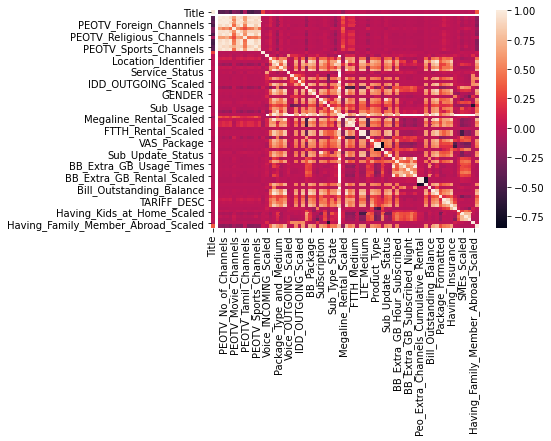

In [11]:
cor_df = le_data.drop(columns=[col for col in le_data if col not in ALL_COLUMNS])
corr = cor_df.corr()
sns.heatmap(corr)

In [12]:
# select columns (selected features)
cols = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if cols[j]:
                cols[j] = False

selected_columns = cor_df.columns[cols]
print("Selected Columns", selected_columns)
print("\nSelected no of columns", len(selected_columns))

# final dataframe to merge model predictions
le_data = le_data[[USER_COULMN,ITEM_COLUMN,RATING_COLUMN] + list(selected_columns)]

# for column list generation
final_df = final_df[[USER_COULMN,ITEM_COLUMN,RATING_COLUMN] + list(selected_columns)]

Selected Columns Index(['Title', 'Price', 'Monthly_Rental', 'PEOTV_Movie_Channels',
       'PEOTV_Tamil_Channels', 'PEOTV_HD_Pack', 'Voice_INCOMING_Scaled',
       'Location_Identifier', 'Location_Node', 'Package_Type_and_Medium',
       'Model', 'Voice_OUTGOING_Scaled', 'IDD_INCOMING_Scaled',
       'IDD_incoming_country', 'IDD_OUTGOING_Scaled', 'IDD_outgoing_country',
       'BB_Scaled', 'GENDER', 'AGE', 'Subscription', 'Sub_Type', 'Sub_Usage',
       'Sub_Type_State', 'Megaline_Package', 'Megaline_Rental_Scaled',
       'FTTH_Month_Subscribed', 'FTTH_Rental_Scaled', 'LTE_Package',
       'LTE_Rental_Scaled', 'VAS_Package', 'Product_Type', 'VAS_Rental_Scaled',
       'Sub_Update', 'BB_Extra_GB_Amount', 'BB_Extra_GB_Hour_Subscribed',
       'BB_Extra_GB_Usage_Times', 'BB_Extra_GB_Subscribed_Night',
       'BB_Extra_GB_Subscribed_Day', 'Peo_Extra_Channels_Cumulative_Rental',
       'Peo_Extra_Channels_Purchased_Categorical', 'Bill_Outstanding_Balance',
       'Bill_Billing_Status', 'Pa

In [13]:
df_final = final_df.groupby([USER_COULMN, ITEM_COLUMN, RATING_COLUMN]).sum().reset_index()
print(df_final.shape)

(89270, 29)


In [14]:
# df_final.drop(["AGE","Megaline_Rental_Scaled","FTTH_Rental_Scaled","LTE_Rental_Scaled","BB_Extra_GB_Subscribed_Night","BB_Extra_GB_Subscribed_Day","Bill_Outstanding_Balance"],axis=1, inplace = True)

### Functions used in training factorization machine

In [15]:
#subset data
def subsetdata(data, by, subset_quantile):
    filter_standard = data.groupby([by]).size().reset_index(name='counts').counts.quantile(subset_quantile)
    subset_data = data.groupby(by).filter(lambda x: len(x) >= filter_standard)
    
    return filter_standard, subset_data


#split train and test data
def split_testtrain(ratings, fraction):
    #Transform data in matrix format
    colnames = ratings.columns.values
    new_colnames = []
    i = 1
    for col in list(colnames):
        new_colnames.append("{}_{}".format(str(i),str(col)))

    ratings = ratings.rename(index=str, columns=dict(zip(colnames, new_colnames)))
    
    ratings_df = ratings.to_dict(orient="records")
    
    dv = DictVectorizer()
    ratings_mat = dv.fit_transform(ratings_df).toarray()
    
    #Split data
    x_train, x_test, y_train, y_test = train_test_split(ratings_mat[:,1:], ratings_mat[:,:1], test_size=fraction)
    
    return x_train, x_test, y_train.T[0], y_test.T[0]


#One hot encoding
def OneHotEncoding(train,test):
    encoder = OneHotEncoder(handle_unknown='ignore').fit(train)
    train = encoder.transform(train)
    test = encoder.transform(test)
    return train, test


#Gridsearch for the optimal parameter
def param_selection(X, y, n_folds):
    start = time.time()
    grid_param = {  
    'n_iter' : np.arange(0,120,25)[1:],
    'rank' :  np.arange(2,12,4),
    }
    grid_search = GridSearchCV(als.FMRegression(l2_reg_w=0.1,l2_reg_V=0.1), cv=n_folds, param_grid=grid_param, verbose=10)
    grid_search.fit(X, y)
    grid_search.best_params_
    print(time.time()-start)
    return grid_search.best_params_


def rec_coverage(x_test, y_test, prediction, rec_num):
    ratings = pd.DataFrame()
    ratings['user'] = x_test[:,0]
    ratings['package'] = x_test[:,1]
    ratings['rating'] = y_test
    
    pred = ratings.copy()
    pred['rating'] = prediction
    
    rating_table = pd.pivot_table(ratings, index='user', columns = 'package', values = 'rating')
    pred_table = pd.pivot_table(pred, index='user', columns = 'package', values = 'rating')
    
    rec_movies = []
    rec = pred_table - rating_table
    for user in rec.index:
            rec_item = pred_table.loc[user,:].sort_values(ascending = False).head(rec_num).index.tolist()
            rec_movies += rec_item
    n_rec = len(set(rec_movies))
    n_movies = pred_table.shape[1]
    coverage = round(float(n_rec)/n_movies,2)
    
    return coverage


def create_plot(x1, x2, x3, y1, y2, y3, kind):
    pal = sns.color_palette("Set2")
    
    matplt.figure.Figure(figsize=(5000,5000))
    plt.plot(x1, y1, c=pal[0], label="Filter-User", linewidth=3)
    plt.plot(x2, y2, c=pal[1], label="Filter-Package", linewidth=3)
    plt.plot(x3, y3, c=pal[2], label="Filter-Both", linewidth=3)
    plt.legend(loc='best', fontsize=12)
    plt.xticks(fontsize=12);
    plt.yticks(fontsize=12);
    plt.xlabel("Sampled Data Size", fontsize=14);
    plt.ylabel(kind, fontsize=14);
    plt.title(kind, loc='center', fontsize=16);
    plt.show()

### Factorization Machine

In [16]:
def FieldFactorizationMachine(ratings, subset_by, subset_quantile, op_iter, op_rank):
    
    #Initialize output
    final_output = pd.DataFrame()
    result_dict = []
    n_iteration = 1 
    last_RMSE = 100
    threshold = 0
    
    for quantile in subset_quantile:
        print("---Running iteration " + str(n_iteration) + " ---")
        print("---Subsetting Original Data---")
        
        #subset original data
        if subset_by == USER_COULMN:
            filter_standard, subset_ratings = subsetdata(ratings, USER_COULMN, quantile)
        elif subset_by == ITEM_COLUMN:
            filter_standard, subset_ratings = subsetdata(ratings, ITEM_COLUMN, quantile)
        else:
            f1, subset_u = subsetdata(ratings, USER_COULMN, quantile)
            f2, subset_ratings = subsetdata(subset_u, ITEM_COLUMN, quantile)
            filter_standard = "("+str(f1)+","+str(f2)+")"
        
        n_users = subset_ratings[USER_COULMN].unique().shape[0]
        n_items = subset_ratings[ITEM_COLUMN].unique().shape[0]
        n_size = subset_ratings.shape[0]*subset_ratings.shape[1]
        
        sparsity = round(float(subset_ratings.shape[0]) / float(n_users*n_items),2)
        
        print("---Spliting Test and Train Data---")
        #split test and train data
        xtrain, xtest, ytrain, ytest = split_testtrain(subset_ratings, 0.2)

        print("---Encoding Data---")
        #encode data
        xtrain_enc, xtest_enc = OneHotEncoding(xtrain, xtest)
        
       
        start = time.time()
        print("---Factorization Machine---")
        #Factorization machine
        fm = als.FMRegression(n_iter=op_iter, rank=op_rank, l2_reg_w=0.1, l2_reg_V=0.1)
        fm.fit(xtrain_enc, ytrain)
        predictions = fm.predict(xtest_enc)
        spent_time = time.time() - start
        #Evaluation metrics
        rmse = sqrt(mean_squared_error(ytest,predictions))
        mae = mean_absolute_error(ytest,predictions)
        coverage = rec_coverage(xtest, ytest, predictions, 10)
        
        if rmse < last_RMSE:
            last_RMSE = rmse
            threshold = filter_standard
            out = pd.DataFrame()
            out['user'] = xtest[:,0]
            out['package'] = xtest[:,1]
            out['rating'] = ytest
            out['prediction'] = predictions
            
            final_output = out.copy()
        
        result_dict.append([quantile, filter_standard, n_size, n_users, n_items, sparsity, op_iter, op_rank, spent_time, mae, rmse, coverage])
        n_iteration += 1
    
    results = pd.DataFrame(result_dict)
    results.columns = ["Quantile", "Threshold", "Size", "Num_Users", "Num_Packages", "Sparsity", "OP_Iter", "OP_Rank", "Running Time", "MAE", "RMSE", "Coverage"]
    
    final_output.to_csv("FFM_Output_"+subset_by+"_"+str(threshold)+".csv", sep=',', encoding='utf-8', index=False)
    
    return results

In [17]:
quantile_list = np.arange(0.1,1,0.1)

### Subset method 1 - Subset data from less prolific users to prolific users

In [18]:
accuracy_matrix_user = FieldFactorizationMachine(df_final, USER_COULMN, quantile_list, 2, 2)

---Running iteration 1 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 2 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 3 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 4 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 5 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 6 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 7 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running it

In [19]:
accuracy_matrix_user

,Quantile,Threshold,Size,Num_Users,Num_Packages,Sparsity,OP_Iter,OP_Rank,Running Time,MAE,RMSE,Coverage
0,0.1,3.0,2513981,17482,48,0.10,2,2,339.482737,0.288462,0.775839,1.0
1,0.2,3.0,2513981,17482,48,0.10,2,2,326.015999,0.090004,0.191309,1.0
2,0.3,4.0,2297177,14990,46,0.11,2,2,258.224544,0.118167,0.327074,1.0
3,0.4,4.0,2297177,14990,46,0.11,2,2,257.005630,0.202351,0.393165,1.0
4,0.5,5.0,1777613,10511,45,0.13,2,2,139.824927,0.143322,0.244829,1.0
5,0.6,5.0,1777613,10511,45,0.13,2,2,140.119981,0.132444,0.238783,1.0
6,0.7,5.0,1777613,10511,45,0.13,2,2,140.079103,0.182072,0.360749,1.0
7,0.8,6.0,1080018,5700,44,0.15,2,2,45.675382,0.110199,0.187851,1.0
8,0.9,7.0,489114,2304,42,0.17,2,2,8.516701,0.049827,0.076272,1.0


In [39]:
accuracy_matrix_user = accuracy_matrix_user.iloc[:-1,:]

In [40]:
accuracy_matrix_user.to_csv("data/up-selling/peotv/fm/user_fm_summary.csv")

In [41]:
#size_norm_u = normalize(accuracy_matrix_user['Size'][:,np.newaxis], axis=0).ravel()
size_norm_u = 1-np.array(accuracy_matrix_user['Quantile'])

In [42]:
time_u = np.array(accuracy_matrix_user['Running Time'])
mae_u = np.array(accuracy_matrix_user['MAE'])
rmse_u = np.array(accuracy_matrix_user['RMSE'])
coverage_u = np.array(accuracy_matrix_user['Coverage'])

### Subset method 2 - Subset data from less popular items to popular items

In [22]:
accuracy_matrix_package = FieldFactorizationMachine(ratings, ITEM_COLUMN, quantile_list, 2, 2)

---Running iteration 1 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 2 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 3 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 4 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 5 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 6 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 7 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---


In [24]:
accuracy_matrix_package

,Quantile,Threshold,Size,Num_Users,Num_Packages,Sparsity,OP_Iter,OP_Rank,Running Time,MAE,RMSE,Coverage
0,0.1,3.7,267783,19018,43,0.11,2,2,378.062516,0.038649,0.106619,1.0
1,0.2,8.4,267684,19018,38,0.12,2,2,383.068762,0.065516,0.195395,1.0
2,0.3,29.2,267429,19015,33,0.14,2,2,377.439953,0.060123,0.213862,1.0
3,0.4,55.6,266919,19015,29,0.16,2,2,383.080878,0.046145,0.177785,1.0
4,0.5,119.5,265815,19013,24,0.19,2,2,377.437579,0.048482,0.120894,1.0
5,0.6,192.4,263556,19004,19,0.24,2,2,370.695427,0.067697,0.270588,1.0
6,0.7,436.2,260634,18987,15,0.31,2,2,374.814679,0.069520,0.222109,1.0
7,0.8,758.6,251601,18904,10,0.44,2,2,347.775583,0.133309,0.556586,1.0
8,0.9,2130.9,234111,18627,5,0.84,2,2,309.385412,0.094073,0.353845,1.0


In [31]:
accuracy_matrix_package.to_csv("data/up-selling/peotv/fm/item_fm_summary.csv")

In [25]:
#size_norm_m = normalize(accuracy_matrix_movie['Size'][:,np.newaxis], axis=0).ravel()
size_norm_m = 1-np.array(accuracy_matrix_package['Quantile'])

In [26]:
time_m = np.array(accuracy_matrix_package['Running Time'])
mae_m = np.array(accuracy_matrix_package['MAE'])
rmse_m = np.array(accuracy_matrix_package['RMSE'])
coverage_m = np.array(accuracy_matrix_package['Coverage'])

### Subset method 3 - Subset data in both user and item directions

In [27]:
accuracy_matrix_both = FieldFactorizationMachine(ratings, "both", quantile_list, 2, 2)

---Running iteration 1 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 2 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 3 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 4 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 5 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 6 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 7 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running it

In [28]:
accuracy_matrix_both

,Quantile,Threshold,Size,Num_Users,Num_Packages,Sparsity,OP_Iter,OP_Rank,Running Time,MAE,RMSE,Coverage
0,0.1,"(3.0,3.7)",260040,17482,43,0.12,2,2,332.952736,0.137296,0.378423,1.0
1,0.2,"(3.0,7.0)",259992,17482,40,0.12,2,2,330.595499,0.065252,0.182505,1.0
2,0.3,"(4.0,31.500000000000014)",237252,14990,32,0.16,2,2,254.120752,0.055630,0.197102,1.0
3,0.4,"(4.0,55.0)",236880,14990,29,0.18,2,2,254.872916,0.055734,0.174912,1.0
4,0.5,"(5.0,100.0)",182199,10511,23,0.25,2,2,136.720000,0.123177,0.256201,1.0
5,0.6,"(5.0,153.0)",180783,10508,19,0.30,2,2,133.610536,0.032597,0.082423,1.0
6,0.7,"(5.0,390.7999999999997)",177639,10500,14,0.40,2,2,133.905865,0.058475,0.175715,1.0
7,0.8,"(6.0,392.79999999999995)",102963,5669,9,0.67,2,2,41.490882,0.058153,0.159919,1.0
8,0.9,"(7.0,577.5999999999997)",43296,2258,5,1.28,2,2,6.882907,0.039977,0.075766,1.0


In [33]:
accuracy_matrix_both.to_csv("data/up-selling/peotv/fm/user_item_both_fm_summary.csv")

In [29]:
#size_norm_b = normalize(accuracy_matrix_both['Size'][:,np.newaxis], axis=0).ravel()
size_norm_b = 1-np.array(accuracy_matrix_both['Quantile'])

In [30]:
time_b = np.array(accuracy_matrix_both['Running Time'])
mae_b = np.array(accuracy_matrix_both['MAE'])
rmse_b = np.array(accuracy_matrix_both['RMSE'])
coverage_b = np.array(accuracy_matrix_both['Coverage'])

### Evaluation

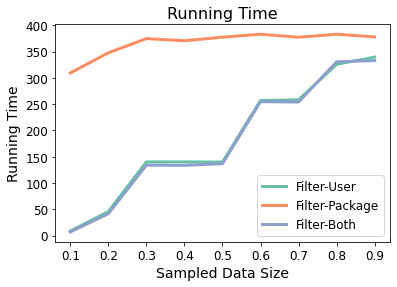

In [34]:
create_plot(size_norm_u, size_norm_m, size_norm_b, time_u, time_m, time_b, "Running Time")

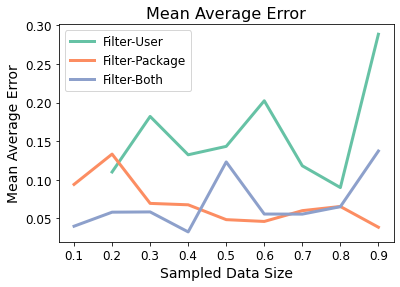

In [43]:
create_plot(size_norm_u, size_norm_m, size_norm_b, mae_u, mae_m, mae_b, "Mean Average Error")

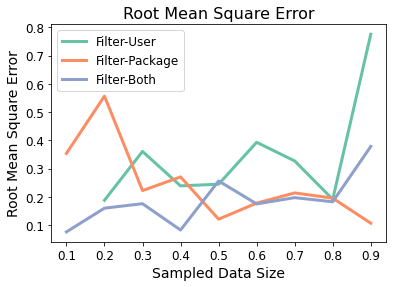

In [44]:
create_plot(size_norm_u, size_norm_m, size_norm_b, rmse_u, rmse_m, rmse_b, "Root Mean Square Error")

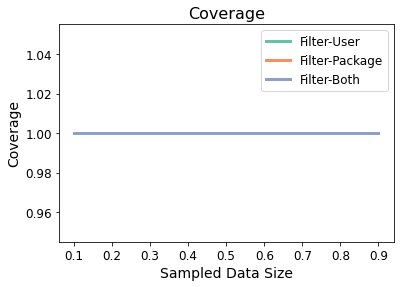

In [37]:
create_plot(size_norm_u, size_norm_m, size_norm_b, coverage_u, coverage_m, coverage_b, "Coverage")